# Tarefa: 07 de maio de 2025

## 💡 Ideia central
Iniciar as primeiras simulações em Julia seguindo o exemplo da seção 1.7.2 do livro _Multiscale Methods Averaging and Homogenization_.



## AFAZERES
1. Ler a documentação da página toda
1. Fazer a documentação dos códigos utilizados
2. Definir o método mais adequado
3. Ver reprodutibilidade
4. Explorar o [Ensemble Simulations](https://docs.sciml.ai/DiffEqDocs/stable/tutorials/sde_example/#Ensemble-Simulations)

## 🎯 Apresentação do problema

Trabalharemos com o exemplo apresentado abaixo:

$$
\begin{aligned}
    \frac{dx}{dt} &= x - x^3 + \frac{\lambda}{\varepsilon} y_2, \\
    \frac{dy_1}{dt} &= \frac{10}{\varepsilon^2} (y_2 - y_1), \\
    \frac{dy_2}{dt} &= \frac{1}{\varepsilon^2} (28 y_1 - y_2 - y_1 y_3), \\
    \frac{dy_3}{dt} &= \frac{1}{\varepsilon^2} \left( y_1 y_2 - \frac{8}{3} y_3 \right).
\end{aligned}
$$

O exemplo é escolhido, pois ele é totalmente determinístico, mas se comporta de forma estocástica quando eliminamos uma variável caótica rápida. Temos que o vetor $y=(y_1, y_2, y_3)^T$ é do sistema de Lorenz e possui solução ergódica.

_Observação:_ Em matemática, a ergodicidade expressa a ideia de que um ponto de um sistema em movimento, seja um sistema dinâmico ou um processo estocástico, acabará visitando todas as partes do espaço em que o sistema se move, em um sentido uniforme e aleatório. ([Fonte](https://en.m.wikipedia.org/wiki/Ergodicity))

---

### Interpretações da construção do sistema

1. **Sobre $f_0(x, y)$ e a condição de centralização**

   Na página 166 do livro, a função $f_0(x, y)$ representa o termo induzido pelos modos rápidos sobre a dinâmica lenta. Ela deve satisfazer a ^condição de centralização**, que é dada por:

   $$
   \int_Y f_0(x, y) \, \rho_\infty(y; x) \, dy = 0
   $$

   onde $\rho_\infty$ é a densidade da medida invariante do sistema rápido (por exemplo, o sistema de Lorenz). Essa condição é uma **hipótese fundamental** para garantir que o termo médio desapareça no limite $\varepsilon \to 0$, o que permite a aplicação da teoria de homogenização estocástica.  
   No caso discutido, $f_0(x, y) = \frac{\lambda}{\varepsilon} y_2$, e sabemos que a média de $y_2$ ao longo do atrator de Lorenz é zero, satisfazendo essa condição.

2. **Origem da equação (11.7.9)**  
   A equação

   $$
   \frac{dX}{dt} = X - X^3 + \sigma \frac{dW}{dt}
   $$

   é um caso particular da equação geral apresentada como (11.3.6):

   $$
   \frac{dX}{dt} = F(X) + A(X) \frac{dW}{dt}
   $$

   Nesse caso:

   - O termo de deriva é $F(X) = X - X^3$,
   - O coeficiente de difusão é constante: $A(X) = \sigma$.

   Ambos os termos são definidos com base no **Resultado 11.7**, que fornece as expressões explícitas para $F(X)$ e $A(X)$ a partir de integrais temporais de correlação da função $f_0$:

   $$
   A_0(x) = 2 \int_0^\infty \left( \lim_{T \to \infty} \frac{1}{T} \int_0^T f_0(x, \varphi_x^s(y)) \otimes f_0(x, \varphi_x^{t+s}(y)) \, ds \right) dt
   $$

   $$
   F_0(x) = \int_0^\infty \left( \lim_{T \to \infty} \frac{1}{T} \int_0^T \nabla_x f_0(x, \varphi_x^{t+s}(y)) f_0(x, \varphi_x^s(y)) \, ds \right) dt
   $$

   A equação (11.7.9) é, portanto, uma aplicação concreta do resultado geral de homogenização do capítulo 11.


## 🚀 Primeiras simulações

O presente código visa realizar as primeiras simulações do sistema sem tanta preocupação com detalhes da linguagem e uma manipulação matemática tão rigorosa. Interprete a seção como um primeiro passo.

In [6]:
using DifferentialEquations, Plots

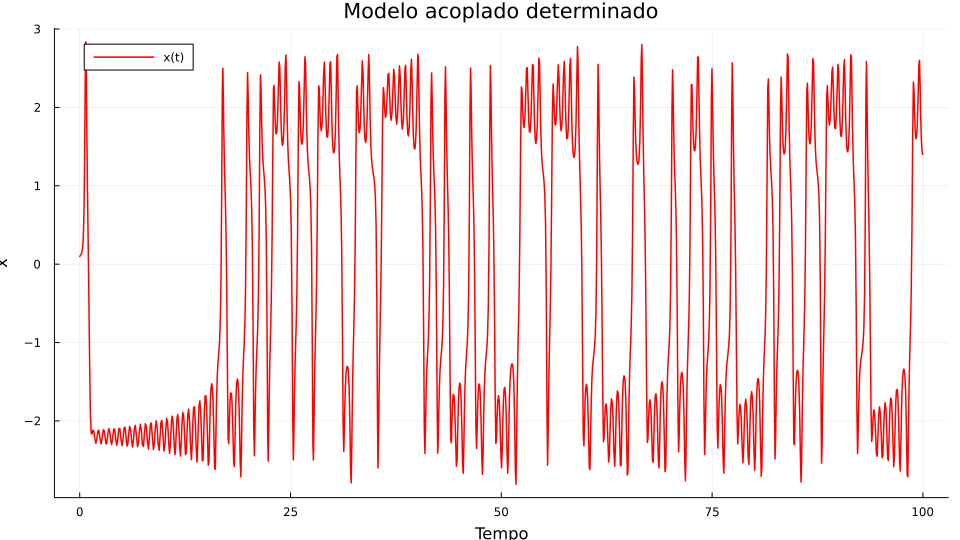

In [ ]:
# Primeira exploração do sistema original
function f(du, u, p, t)
    lambda = 1.0
    epsilon = 0.01

    x, y1, y2, y3 = u

    du[1] = x - x^3 + (lambda/epsilon) * y2
    du[2] = (10 / epsilon^2) * (y2 - y1)
    du[3] = (1 / epsilon^2) * (28*y1 - y2 - y1*y3)  
    du[4] = (1 / epsilon^2) * (y1*y2 - (8/3)*y3)
end

u0 = [0.1, 0.01, 0.01, 0.01]
tspan = (0.0, 100.0)
prob = ODEProblem(f, u0, tspan)
sol = solve(prob)

plot(sol.t, sol[1, :];
     label = "x(t)",
     xlabel = "Tempo",
     ylabel = "x",
     title = "Modelo acoplado determinado",
     size = (960, 540),
     color = :red,
     linewidth = 1.5)

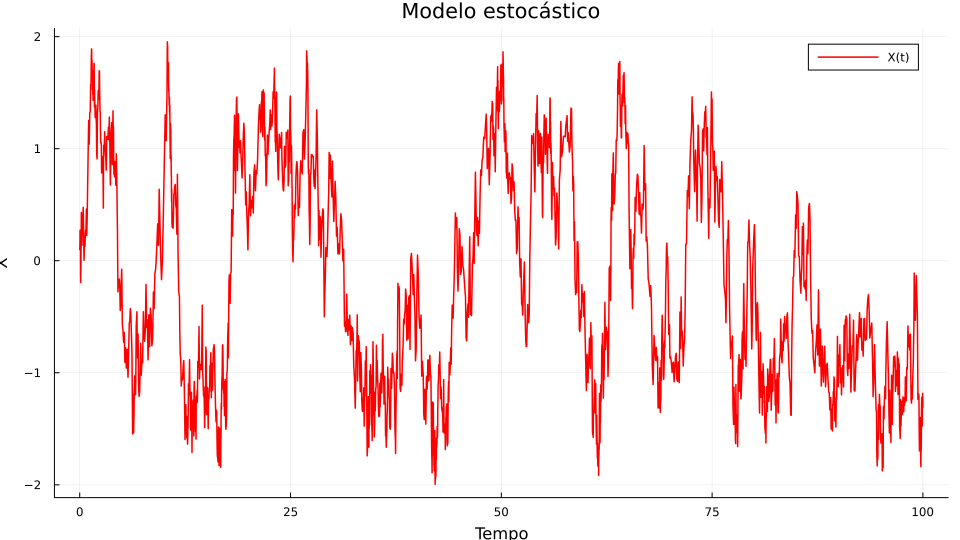

In [8]:
# Primeira exploração do sistema estocástico

sigma = 1.0
x0 = 0.1
tspan = (0.0, 100.0)

f1(X, p, t) = X - X^3
f2(X, p, t) = sigma

W = WienerProcess(0.0, 0.1, 0.0)
prob = SDEProblem(f1, f2, x0, tspan, noise=W)
sol = solve(prob, SRIW1(), dt=0.01)

plot(sol.t, sol.u;
     label = "X(t)",
     xlabel = "Tempo",
     ylabel = "X",
     title = "Modelo estocástico",
     size = (960, 540),
     color = :red,
     linewidth = 1.5)

## 🖥️ Aprofundamento

### Métodos para equações diferenciais estocásticas (SDE Solvers)

Lista de métodos disponíveis em: https://docs.sciml.ai/DiffEqDocs/stable/solvers/sde_solve/

